In [2]:
import xgboost
from xgboost import XGBRegressor

In [3]:
file = "/Users/shutinggu/Desktop/1001-project/renttherunway_final_data.json"
df = pd.read_json(file,lines=True)
df.shape

(192544, 15)

In [4]:
df=df.drop(columns=['user_id', 'item_id','review_date','review_summary','review_text','fit'])
df.shape

(192544, 9)

In [5]:
# transfer bust size into bust size and cups
df=df.dropna()
df['cups'] = df['bust size'].str.extract(r'([a-z])')
labels = df['cups'].astype('category').cat.categories.tolist()
replace_map = {'cups' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print('--- map cups to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)
df['bust size'] = df['bust size'].str.extract('(\d+)').astype(int)
# remove lbs after 'weight'
df['weight'] = df['weight'].str.extract('(\d+)').astype(int)
# parse height to usable numerical format
def parse_height(ht):
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_
df['height'] = df['height'].apply(lambda x:parse_height(x))
# change 'party: cocktail' in 'rented for' to 'others'
df.loc[df['rented for'] == 'party: cocktail', df.columns == 'rented for'] = 'other'

--- map cups to numerical value ---
{'cups': {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9}}


In [6]:
df['category'].unique()

array(['romper', 'gown', 'dress', 'sheath', 'leggings', 'sweater',
       'jacket', 'shirtdress', 'jumpsuit', 'shift', 'top', 'shirt',
       'mini', 'skirt', 'maxi', 'pants', 'suit', 'coat', 'blouse',
       'trench', 'cape', 'bomber', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'down', 'culottes',
       'midi', 'legging', 'print', 'pant', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'trouser', 'kaftan', 'overalls', 'jogger',
       'tee', 'combo', 'henley', 'blouson', 'pullover', 'turtleneck',
       'trousers', 'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight',
       'kimono', 'cami', 'for', 'crewneck', 'skirts', 'parka',
       'buttondown', 'skort', 'sweatershirt', 'jeans', 'sweatpants'],
      dtype=object)

In [7]:
df.loc[df['category'].isin(['sweater','shirt','blouse','vest','tank','tunic','print','sweatshirt',
                            'tee','blouson','turtleneck','hoodie','t-shirt','cami','crewneck',
                            'buttondown','sweatershirt'
                           ]),df.columns=='category']='tops'
df.loc[df['category'].isin(['pants','down','culottes','pant','trouser','culotte','jogger',
                            'trousers','jeans', 'sweatpants'
                           ]),df.columns=='category']='bottoms'
df.loc[df['category'].isin(['ballgown']),df.columns=='category']='gown'
df.loc[df['category'].isin(['leggings','legging']),df.columns=='category']='active'
df.loc[df['category'].isin(['jacket','trench','cape','bomber','blazer','duster','poncho',
                            'cardigan','peacoat','pullover','overcoat','parka'
                           ]),df.columns=='category']='coat'
df.loc[df['category'].isin(['mini','midi','skirts']),df.columns=='category']='skirt'
df.loc[df['category'].isin(['jumpsuit']),df.columns=='category']='romper'
df.loc[df['category'].isin(['sheath','shift','maxi','shirtdress','frock','kaftan','caftan'
                           ]),df.columns=='category']='dress'
df.loc[df['category'].isin(['overalls','combo','henley','tight','kimono','for','skort']),df.columns=='category']='other'

In [8]:
df.shape

(146381, 10)

In [9]:
df.info()
df= pd.get_dummies(df, columns=['body type','category','rented for'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 146381 entries, 0 to 192543
Data columns (total 10 columns):
age           146381 non-null float64
body type     146381 non-null object
bust size     146381 non-null int64
category      146381 non-null object
height        146381 non-null float64
rating        146381 non-null float64
rented for    146381 non-null object
size          146381 non-null int64
weight        146381 non-null int64
cups          146381 non-null int64
dtypes: float64(3), int64(4), object(3)
memory usage: 12.3+ MB


In [10]:
x=[2,4,6,8,10]
df['rating'].value_counts()

10.0    94291
8.0     40761
6.0      8341
4.0      2205
2.0       783
Name: rating, dtype: int64

In [11]:
y=[94291,40761,8341,2205,783]

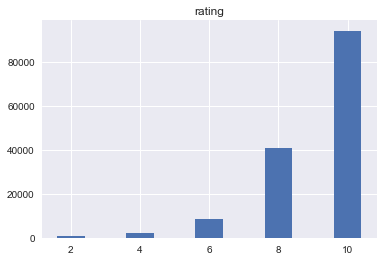

In [12]:
plt.bar(x,y[::-1])
plt.title('rating')
plt.show()

In [48]:
x=df.drop(columns=['rating'],axis=1)
y=df['rating']
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.33)

In [49]:
#Linear Regression
lg=LinearRegression(normalize=True).fit(x_train,y_train)
lg_train_pred=lg.predict(x_train)
lg_train_mse=mean_squared_error(y_train, lg_train_pred)
print('Linear Regression Train MSE:',lg_train_mse)
lg_test_pred=lg.predict(x_test)
lg_test_mse=mean_squared_error(y_test, lg_test_pred)
print('Linear Regression Test MSE:',lg_test_mse)

Linear Regression Train MSE: 2.0295173573451417
Linear Regression Test MSE: 2.0584332881465204


In [70]:
#Decision Tree Regressor
leaf=[2,10,20,50,100,200,500,1000,2000,5000,10000]
train_mse=[]
test_mse=[]
for i in leaf:
    print('max_depth is:', i)
    dt=DecisionTreeRegressor(min_samples_split=i,min_samples_leaf=10, max_depth=10).fit(x_train,y_train)
    dt_train_pred=dt.predict(x_train)
    dt_train_mse=mean_squared_error(y_train, dt_train_pred)
    train_mse.append(dt_train_mse)
    print('Decision Tree Regressor Train MSE:',dt_train_mse)
    dt_test_pred=dt.predict(x_test)
    dt_test_mse=mean_squared_error(y_test, dt_test_pred)
    test_mse.append(dt_test_mse)
    print('Decision Tree Regressor Test MSE:',dt_test_mse)



max_depth is: 2
Decision Tree Regressor Train MSE: 1.9777808015918135
Decision Tree Regressor Test MSE: 2.091141228594522
max_depth is: 10
Decision Tree Regressor Train MSE: 1.9777808015918135
Decision Tree Regressor Test MSE: 2.090896271471335
max_depth is: 20
Decision Tree Regressor Train MSE: 1.9777808015918135
Decision Tree Regressor Test MSE: 2.091218014664182
max_depth is: 50
Decision Tree Regressor Train MSE: 1.9870930527934216
Decision Tree Regressor Test MSE: 2.0819624329642834
max_depth is: 100
Decision Tree Regressor Train MSE: 1.992344425493028
Decision Tree Regressor Test MSE: 2.0786977476562782
max_depth is: 200
Decision Tree Regressor Train MSE: 1.9999467559188917
Decision Tree Regressor Test MSE: 2.0719695145990134
max_depth is: 500
Decision Tree Regressor Train MSE: 2.009289591108761
Decision Tree Regressor Test MSE: 2.0639601119252697
max_depth is: 1000
Decision Tree Regressor Train MSE: 2.0143414352214406
Decision Tree Regressor Test MSE: 2.060883109007018
max_depth 

In [73]:
def plot_learning_curve(leaf, train_mse,test_mse):
    plt.plot(leaf, train_mse, label='Training', linewidth=3)
    plt.plot(leaf, test_mse, label='Test', linewidth=3)

    plt.xticks(fontsize=10);
    plt.yticks(fontsize=10);
    plt.xlabel('min_samples_split', fontsize=15);
    plt.ylabel('MSE', fontsize=15);
    plt.legend(loc='best', fontsize=13);


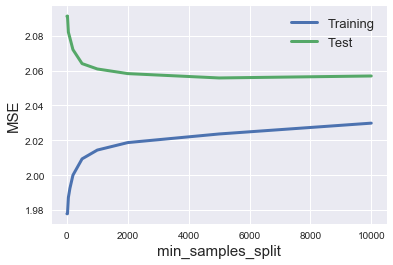

In [74]:
plot_learning_curve(leaf, train_mse,test_mse)

In [27]:
#Random Forest regressor
e=[10,25,50,100,200,500]
train_mse=[]
test_mse=[]
for i in e:
    rm=RandomForestRegressor(max_depth=10,n_estimators=i,min_samples_split=10,min_samples_leaf=10).fit(x_train,y_train)
    rm_train_pred=rm.predict(x_train)
    rm_train_mse=mean_squared_error(y_train, rm_train_pred)
    print('max_depth is:', i)
    train_mse.append(rm_train_mse)
    print('Random Forest Regressor Train MSE:',rm_train_mse)
    rm_test_pred=rm.predict(x_test)
    rm_test_mse=mean_squared_error(y_test, rm_test_pred)
    test_mse.append(rm_test_mse)
    print('Random Forest Regressor Test MSE:',rm_test_mse)
    

max_depth is: 10
Random Forest Regressor Train MSE: 1.973970591815124
Random Forest Regressor Test MSE: 2.0333296057532833
max_depth is: 25
Random Forest Regressor Train MSE: 1.9725409581459477
Random Forest Regressor Test MSE: 2.028308697739766
max_depth is: 50
Random Forest Regressor Train MSE: 1.968307465068656
Random Forest Regressor Test MSE: 2.0271451925379416
max_depth is: 100
Random Forest Regressor Train MSE: 1.967452350005898
Random Forest Regressor Test MSE: 2.0262200531109293
max_depth is: 200
Random Forest Regressor Train MSE: 1.967728208710367
Random Forest Regressor Test MSE: 2.025753468252897
max_depth is: 500
Random Forest Regressor Train MSE: 1.9668387584242237
Random Forest Regressor Test MSE: 2.025697261616974


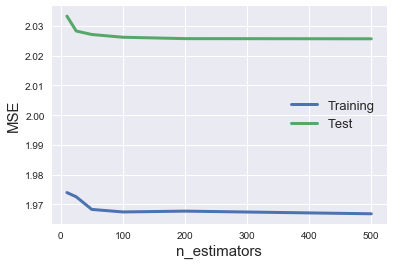

In [28]:
plot_learning_curve(e, train_mse,test_mse)

In [19]:
#Gradient Boosting Regressor
max_depth=[1, 5, 10, 15, 20, 30]
for i in max_depth:
    gb=GradientBoostingRegressor(loss='ls', learning_rate=0.001, n_estimators=300, min_samples_split=10, max_depth=i).fit(x_train,y_train)
    gb_train_pred=gb.predict(x_train)
    gb_train_mse=mean_squared_error(y_train, gb_train_pred)
    print('max_depth is:', i)
    print('Gradient Boosting Regressor Train MSE:',gb_train_mse)
    gb_test_pred=gb.predict(x_test)
    gb_test_mse=mean_squared_error(y_test, gb_test_pred)
    print('Gradient Boosting Regressor Test MSE:',gb_test_mse)

max_depth is: 1
Gradient Boosting Regressor Train MSE: 2.050538560535862
Gradient Boosting Regressor Test MSE: 2.086799430361565
max_depth is: 5
Gradient Boosting Regressor Train MSE: 2.0403434599366936
Gradient Boosting Regressor Test MSE: 2.0787505905064427
max_depth is: 10
Gradient Boosting Regressor Train MSE: 2.014517172720119
Gradient Boosting Regressor Test MSE: 2.0772604218489947
max_depth is: 15
Gradient Boosting Regressor Train MSE: 1.9367591092495322
Gradient Boosting Regressor Test MSE: 2.0795023012802036


KeyboardInterrupt: 

In [46]:
#XGBoosting
xgb=XGBRegressor(max_depth=10, n_estimators=1000, learning_rate=0.01).fit(x_train, y_train)
xgb_train_pred=xgb.predict(x_train)
xgb_train_mse=mean_squared_error(y_train, xgb_train_pred)
print('XGBoosting Regressor Train MSE:',xgb_train_mse)
xgb_test_pred=xgb.predict(x_test)
xgb_test_mse=mean_squared_error(y_test, xgb_test_pred)
print('XGBoosting Regressor Test MSE:',xgb_test_mse)

KeyboardInterrupt: 